##### Copyright 2018 The TensorFlow Authors.

In [134]:
# Autor: TensorFlow
# Obtenido de https://www.tensorflow.org/tutorials/images/classification?hl=es-419
# Adaptado por: Jesús Rojas Vargas

# Modelo de clasificación de flores en imágenes

Este tutorial muestra como crear y entrenar un modelo de clasificación de imágenes, especificamente flores usando el modelo de `tf.keras.Sequential`. 

El fllujo de trabajo en el tutorial es el siguiente:

1. Crear el conjunto de datos
2. Construir un modelo
3. Entrenar el modelo
4. Testear el modelo
5. Mejor el modelo
6. Exportar el modelo a TF Lite
7. Optimizar el modelo de TF LIte con distintas técnicas


## Bibliotecas necesarias


In [ ]:
!pip install matplotlib

In [ ]:
!pip install tensorflow

In [ ]:
!pip install ai-edge-litert

In [2]:
import matplotlib.pyplot as plt
import os
import PIL 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-10-08 09:35:45.552756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 09:35:45.559683: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 09:35:45.582833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 09:35:45.617446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 09:35:45.627117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 09:35:45.653660: I tensorflow/core/platform/cpu_feature_gu

In [3]:
from ai_edge_litert.interpreter import Interpreter
import numpy as np

## Creación del conjunto de datos

### Descargar el conjunto de datos

El conjunto de datos contiene 5 clases de flores para clasificar

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [6]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir) # Imprime la ruta donde se descargó el dataset

/home/jesusrv/.keras/datasets/flower_photos_extracted


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El directorio cuenta con:",image_count, "imágenes")

El directorio cuenta con: 3670 imágenes


Mostramos algunas de las flores que contiene el conjunto de datos

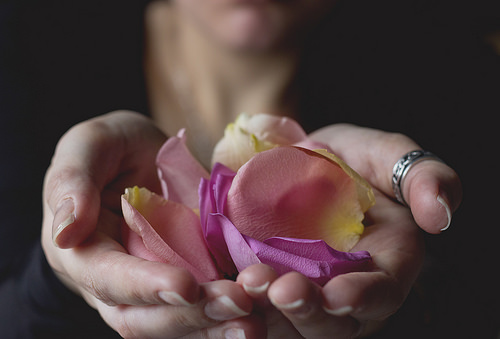

In [8]:
roses = list(data_dir.glob('roses/*')) 
daisy = list(data_dir.glob('daisy/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
dandelion = list(data_dir.glob('dandelion/*'))
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[0]))

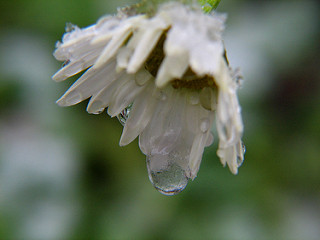

In [9]:
PIL.Image.open(str(daisy[0]))

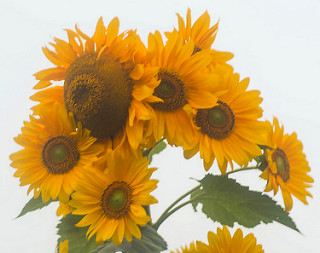

In [10]:
PIL.Image.open(str(sunflowers[0]))

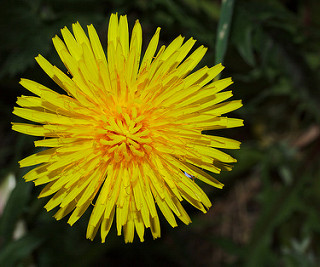

In [11]:
PIL.Image.open(str(dandelion[0]))

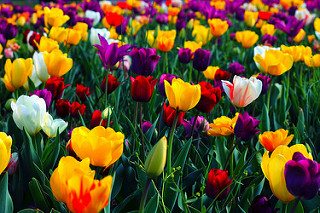

In [12]:
PIL.Image.open(str(tulips[0]))

### Crear el Dataset 

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Es una buena práctica utilizar una división de validación al desarrollar tu modelo. Usa el 80% de las imágenes para el entrenamiento y el 20% para la validación.

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualización de los datos

2024-10-08 09:37:39.060077: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


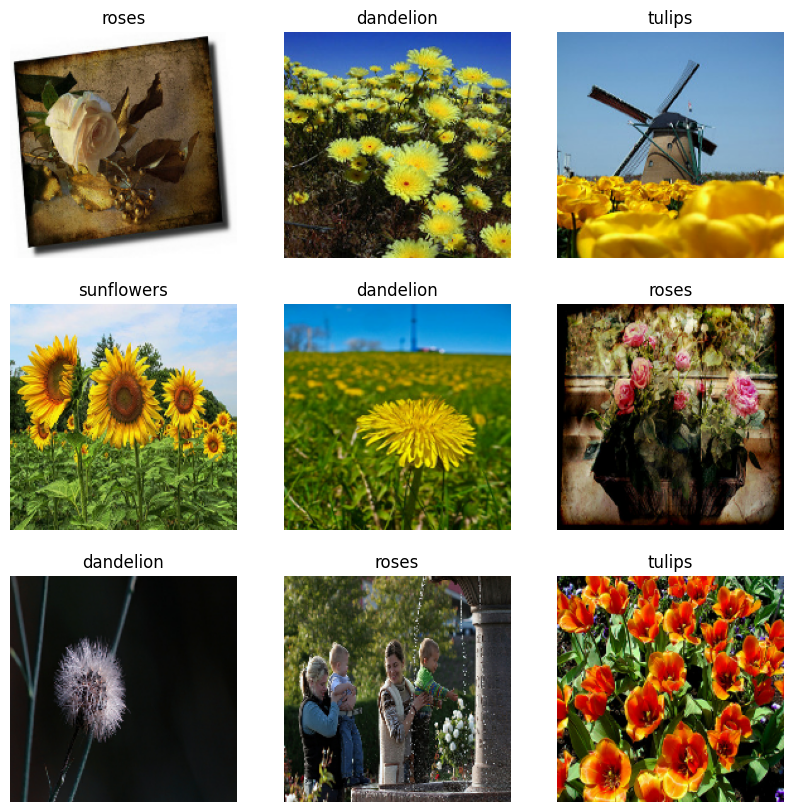

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configurar el conjunto de datos para un mejor rendimiento

Se configura los conjuntos de datos de entrenamiento y validación para mejorar su rendimiento utilizando la caché, el shuffle y el prefetching. Al hacerlo, se optimiza el tiempo de carga de datos y se reduce la posibilidad de que la carga de datos se convierta en un cuello de botella durante el entrenamiento del modelo.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Estandarizar los datos

Convierte los valores de píxeles de las imágenes de un rango de [0, 255] a [0, 1]. Esta normalización es una práctica común en el preprocesamiento de datos para modelos de aprendizaje profundo, ya que puede ayudar a mejorar el rendimiento del modelo durante el entrenamiento.

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))  # Verificamos que se estandarizó

0.015686275 1.0


## Creación del modelo

### Modelo básico de Keras

El modelo Secuencial de Keras consiste en tres bloques de convolución (`tf.keras.layers.Conv2D`) con una capa de max pooling (`tf.keras.layers.MaxPooling2D`) en cada uno de ellos. Hay una capa completamente conectada (`tf.keras.layers.Dense`) con 128 unidades en la parte superior, que se activa mediante una función de activación ReLU (`'relu'`). Este modelo no ha sido ajustado para lograr una alta precisión; el objetivo de este tutorial es mostrar un enfoque estándar.

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), 
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/jesusrv/minitaller_tflite/tflite-env/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilar el modelo

Para este tutorial, se escoge el optimizador `tf.keras.optimizers.Adam` y la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy`. Para ver la precisión de entrenamiento y validación en cada época de entrenamiento se pasa el argumento `metrics` a `Model.compile`.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Entrenamiento del modelo

Entrena el modelo durante 10 épocas utilizando el método `Model.fit` de Keras:

In [33]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 756ms/step - accuracy: 0.3986 - loss: 1.4260 - val_accuracy: 0.5041 - val_loss: 1.3351
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 775ms/step - accuracy: 0.5727 - loss: 1.0690 - val_accuracy: 0.6076 - val_loss: 0.9827
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 755ms/step - accuracy: 0.6184 - loss: 0.9529 - val_accuracy: 0.6594 - val_loss: 0.8952
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 757ms/step - accuracy: 0.6696 - loss: 0.8560 - val_accuracy: 0.6376 - val_loss: 0.9272
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 754ms/step - accuracy: 0.7008 - loss: 0.7879 - val_accuracy: 0.6676 - val_loss: 0.8421
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 767ms/step - accuracy: 0.6803 - loss: 0.8109 - val_accuracy: 0.6894 - val_loss: 0.7517
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 739ms/step - accuracy: 0.7054 - loss: 0.7397 - val_accuracy: 0.7016 - val_loss: 0.7446
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 763ms/step - accuracy: 0.7256 - loss: 0.7022 - val_accu

### Ajustes de Overfitting y Dropout para mejorar la precisión del modelo

Se agragen más datos

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [36]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compilar y entrenar el modelo nuevamente

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - accuracy: 0.2990 - loss: 1.5310 - val_accuracy: 0.5082 - val_loss: 1.2549
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 751ms/step - accuracy: 0.5621 - loss: 1.0616 - val_accuracy: 0.6076 - val_loss: 0.9776
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 786ms/step - accuracy: 0.6258 - loss: 0.9927 - val_accuracy: 0.5163 - val_loss: 1.2670
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 769ms/step - accuracy: 0.6405 - loss: 0.9271 - val_accuracy: 0.6608 - val_loss: 0.9015
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 787ms/step - accuracy: 0.6513 - loss: 0.8775 - val_accuracy: 0.6580 - val_loss: 0.8449
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 771ms/step - accuracy: 0.6783 - loss: 0.8059 - val_accuracy: 0.6771 - val_loss: 0.8037
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 780ms/step - accuracy: 0.7385 - loss: 0.7067 - val_accuracy: 0.6839 - val_loss: 0.7669
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 741ms/step - accuracy: 0.7331 - loss: 0.7242 - val_accu

### Visualización de los resultados de entrenamiento

Luego de aplicar el aumento de datos y la capa de Droput la precision del modelo aumenta

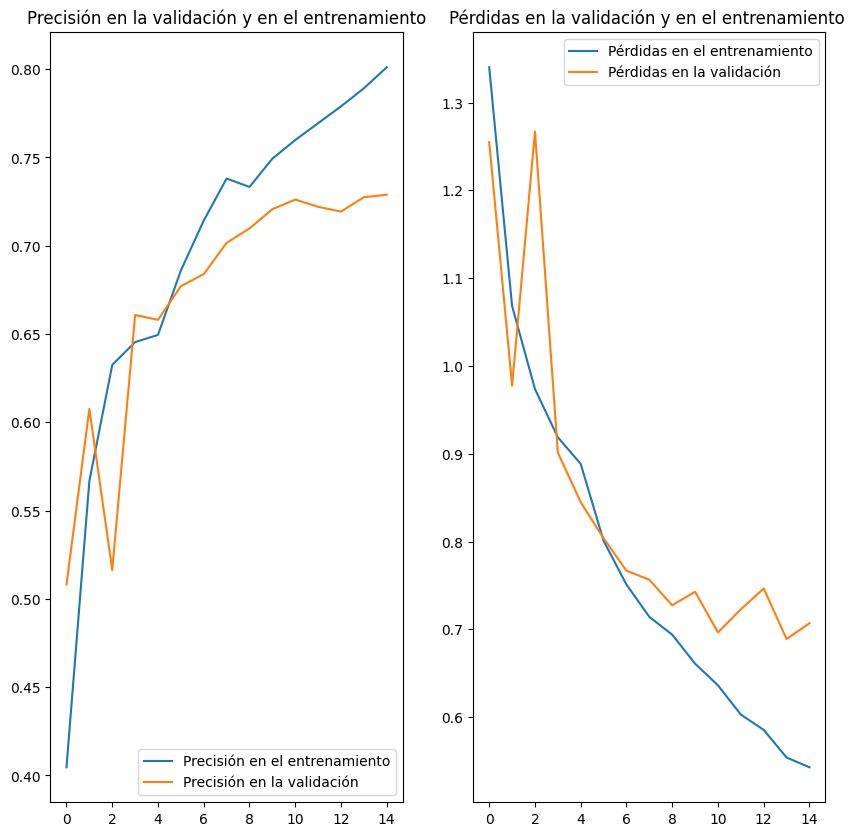

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión en el entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en la validación')
plt.legend(loc='lower right')
plt.title('Precisión en la validación y en el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdidas en el entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdidas en la validación')
plt.legend(loc='upper right')
plt.title('Pérdidas en la validación y en el entrenamiento ')
plt.show()

### Inferencia del modelo

Aqui se realizará la inferencia del modelo con nuevos datos

In [ ]:
flower_url = "https://media.istockphoto.com/id/927047528/vector/sunflower-flower-isolated.jpg?s=612x612&w=0&k=20&c=PO0VpgkzCmtCeke0pjZpOUhmIvAKQ-_IqFcgmt9swMs="
flower_path = tf.keras.utils.get_file('sunflower', origin=flower_url) # Cambiar el nombre del archivo para cada imagen nueva que descargue

# Cargar la imagen y redimensionarla a 180x180
img = tf.keras.utils.load_img(flower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Crear batch

# Realizar predicción
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)

# Mostrar la imagen con la predicción
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicción: {predicted_class}\nConfianza: {confidence:.2f}%")
plt.axis('off') 
plt.show()


In [43]:
# Guardar el modelo Keras en el formato .keras
KERAS_MODEL_NAME = "model.keras"
model.save(KERAS_MODEL_NAME)

## TensorFlow Lite (Lite RT)

Se va a convertir el modelo de Keras a un modelo de TensorFlow Lite para ayudar a los desarrolladores a ejecutar sus modelos en dispositivos móviles, embebidos y de borde.

En este ejemplo, toma el modelo secuencial de Keras entrenado y utiliza la función `tf.lite.TFLiteConverter.from_keras_model` para generar un modelo TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

### Ejecutar el modelo de TensorFlow Lite (Lite RT)

Carga el modelo con el `Interpreter`:

In [132]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = Interpreter(model_path=TF_MODEL_FILE_PATH)

Ahora se usará el modelo de TensorFlow Lite para clasificar imágenes que no se incluyeron en los conjuntos de entrenamiento o validación. Similar a como se realizó anteriormente con el modelo de Keras.

Se probará con una imagen de una flor "dandelion".

<span style="color:blue">Cambia la `url` por distintas imagenes para probrar todas las clases. Adjunte las capturas.</span> 

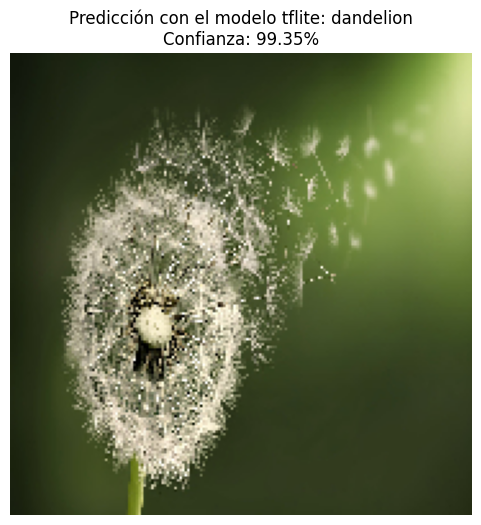

In [133]:
flower_url_tf = "https://www.flowerchimp.com/cdn/shop/articles/dandilieo_1600x.png?v=1680682667"
flower_path_tf = tf.keras.utils.get_file('dandelion2', origin=flower_url_tf)  # Cambia el nombre al descargar un nuevo archivo

# Cargar la imagen y redimensionarla a 180x180
img_tf = tf.keras.utils.load_img(flower_path_tf, target_size=(img_height, img_width))
img_array_tf = tf.keras.utils.img_to_array(img_tf)
img_array_tf = tf.expand_dims(img_array_tf, 0)  # Crear batch

# Preparar el modelo de TensorFlow Lite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Pasar la imagen al modelo TFLite para la inferencia
interpreter.set_tensor(input_details[0]['index'], img_array_tf)
interpreter.invoke()

predictions_lite = interpreter.get_tensor(output_details[0]['index'])
score_lite = tf.nn.softmax(predictions_lite)

predicted_class_lite = class_names[np.argmax(score_lite)]
confidence_lite = 100 * np.max(score_lite)

plt.figure(figsize=(6, 6))
plt.imshow(img_tf)
plt.title(f"Predicción con el modelo tflite: {predicted_class_lite}\nConfianza: {confidence_lite:.2f}%")
plt.axis('off')  
plt.show()


Se imprimen los tamaños de los modelos Keras y TensorFlow Lite para comparación

In [47]:
keras_model_size_bytes = os.path.getsize('model.keras')
keras_model_size_mb = keras_model_size_bytes / (1024 ** 2)
print(f"Tamaño del modelo Keras: {keras_model_size_mb:.2f} MB")

tflite_model_size_bytes = os.path.getsize('model.tflite')
tflite_model_size_mb = tflite_model_size_bytes / (1024 ** 2)
print(f"Tamaño del modelo TensorFlow Lite: {tflite_model_size_mb:.2f} MB")

Tamaño del modelo Keras: 45.71 MB
Tamaño del modelo TensorFlow Lite: 15.22 MB


### Optimización del modelo TF lite

En este punto, antes de ejecutar las conversiones, responda. <span style="color:blue">¿Qué espera que suceda con el tamaño y la precisión del modelo .tflite?</span>


#### Dynamic Range Quantization

Esta es la técnica más simple de cuantificación después del entrenamiento. Funciona cuantificando estáticamente los pesos del modelo de punto flotante a enteros de 8 bits.

Las activaciones siempre se almacenan en punto flotante. Para las operaciones que soportan núcleos cuantificados, las activaciones se cuantifican dinámicamente a 8 bits de precisión antes del procesamiento y se des-cuantifican a precisión de punto flotante después del procesamiento.

In [48]:
converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model)
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant = converter_dynamic.convert()

# Guardar el modelo quantizado a float16
with open('tflite_dynamic_quant.tflite', 'wb') as f:
    f.write(tflite_dynamic_quant)

INFO:tensorflow:Assets written to: /tmp/tmp2qawd8kk/assets


INFO:tensorflow:Assets written to: /tmp/tmp2qawd8kk/assets


Saved artifact at '/tmp/tmp2qawd8kk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135666811476928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720751312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720743568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666721574928: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1728404466.031760   23732 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728404466.031802   23732 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-08 10:21:06.032246: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2qawd8kk
2024-10-08 10:21:06.033910: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-08 10:21:06.033936: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp2qawd8kk
2024-10-08 10:21:06.046686: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-08 10:21:06.191604: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp2qawd8kk
2024-10-08 10:21:06.218192: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 185954 microseconds.


In [49]:
tflite_dynamic_quant_bytes = os.path.getsize('tflite_dynamic_quant.tflite')
tflite_dynamic_quant_size_mb = tflite_dynamic_quant_bytes / (1024 ** 2)
print(f"Tamaño del modelo tflite optimizado con rango dinámico: {tflite_dynamic_quant_size_mb:.2f} MB")

Tamaño del modelo tflite optimizado con rango dinámico: 3.81 MB


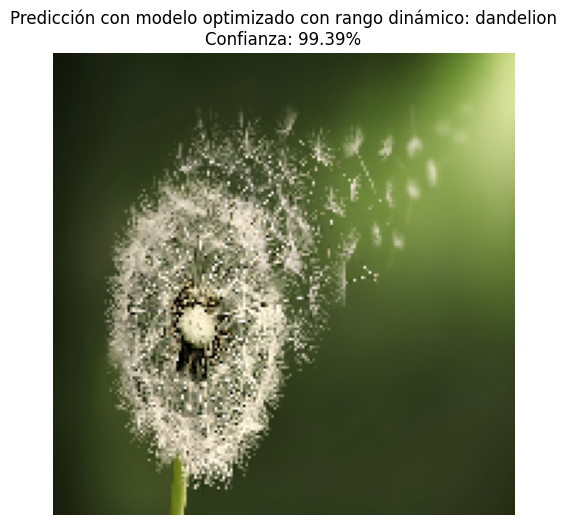

In [50]:
# Prueba de inferencia con el modelo optimizado con rango dinámico 
interpreter_dynamic = Interpreter(model_path='tflite_dynamic_quant.tflite')
interpreter_dynamic.allocate_tensors()
input_details = interpreter_dynamic.get_input_details()
output_details = interpreter_dynamic.get_output_details()

interpreter_dynamic.set_tensor(input_details[0]['index'], img_array_tf)
interpreter_dynamic.invoke()

predictions_dynamic = interpreter_dynamic.get_tensor(output_details[0]['index'])
score_dynamic = tf.nn.softmax(predictions_dynamic)

plt.figure(figsize=(6, 6))
plt.imshow(img_tf)
plt.title(f"Predicción con modelo optimizado con rango dinámico: {class_names[np.argmax(score_dynamic)]}\nConfianza: {100 * np.max(score_dynamic):.2f}%")
plt.axis('off')
plt.show()

#### Full integer Quantization
La cuantización total entera mejora aún más el tamaño del modelo y la latencia al convertir todos los cálculos matemáticos del modelo en cálculos basados en enteros. Esta técnica produce modelos optimizados que son compatibles con dispositivos y aceleradores de hardware que solo manejan enteros.

Para medir el rango dinámico de las activaciones, se pasan algunos ejemplos de entrada reales durante la optimización del modelo. La función `representative_dataset_gen` en el siguiente código pasa los ejemplos de entrada durante la conversión del modelo.

Hay dos formas:

1. Integer Only 
2. Integer with float fallback (using default float input/output)

#### 1. Integer Only Quatization  
Para hacer que el modelo resultante sea compatible con dispositivos que solo admiten enteros, podemos forzar la cuantificación entera total para todas las operaciones, incluidas la entrada y la salida.

El modelo cuantificado solo admitirá entradas de tipo formato int-8. Además, la capa de salida te proporcionará salidas en formato entero. Aquí tienes un código de ejemplo para aplicar la cuantificación solo entera a tu modelo de aprendizaje profundo.

In [ ]:
def representative_dataset_gen():
    for _ in range(100):  # Número de muestras de calibración
        # La entrada del modelo es de la forma (180, 180, 3)
        imagen = np.random.rand(1, 180, 180, 3).astype(np.float32)  # Simulación de datos de entrada
        yield [imagen]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter_int8.inference_input_type = tf.uint8
converter_int8.inference_output_type = tf.uint8

tflite_quant_int8 = converter_int8.convert()

# Guardar el modelo quantizado a int 8
with open('tflite_quant_int8.tflite', 'wb') as f:
    f.write(tflite_quant_int8)

In [113]:
tflite_int_8_bytes = os.path.getsize('tflite_quant_int8.tflite')
tflite_int_8_size_mb = tflite_int_8_bytes / (1024 ** 2)
print(f"Tamaño del modelo optimizado (int8) : {tflite_int_8_size_mb:.2f} MB")

Tamaño del modelo optimizado (int8) : 3.82 MB


#### 2. Float Fallback Quantization 
Este método realiza la cuantización total entera, pero mantiene la entrada y salida en formato flotante de 32 bits (float-32). Sin embargo, el modelo resultante no será compatible con dispositivos o aceleradores que solo manejen enteros en este caso.

In [114]:
converter_int_fallback = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int_fallback.optimizations = [tf.lite.Optimize.DEFAULT]

In [115]:
def representative_dataset_gen():
    for _ in range(100): 
        imagen = np.random.rand(1, 180, 180, 3).astype(np.float32)  # Simulación de datos de entrada
        yield [imagen]
        
converter_int_fallback.representative_dataset = representative_dataset_gen
tflite_int_fallback = converter_int_fallback.convert()

# Guardar el modelo quantizado a float16
with open('tflite_int_fallback.tflite', 'wb') as f:
    f.write(tflite_int_fallback)

INFO:tensorflow:Assets written to: /tmp/tmprywqb4kc/assets


INFO:tensorflow:Assets written to: /tmp/tmprywqb4kc/assets


Saved artifact at '/tmp/tmprywqb4kc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135666811476928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720751312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720743568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666721574928: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/jesusrv/minitaller_tflite/tflite-env/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1728408019.983785   23732 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728408019.983808   23732 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-08 11:20:19.984043: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprywqb4kc
2024-10-08 11:20:19.984872: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-08 11:20:19.984887: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmprywqb4kc
2024-10-08 11:20:19.992411: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-08 11:20:20.096356: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundl

In [116]:
tflite_int_fallback_bytes = os.path.getsize('tflite_int_fallback.tflite')
tflite_int_fallback_size_mb = tflite_int_fallback_bytes / (1024 ** 2)
print(f"Tamaño del modelo TensorFlow Lite (Float16): {tflite_int_fallback_size_mb:.2f} MB")

Tamaño del modelo TensorFlow Lite (Float16): 3.82 MB


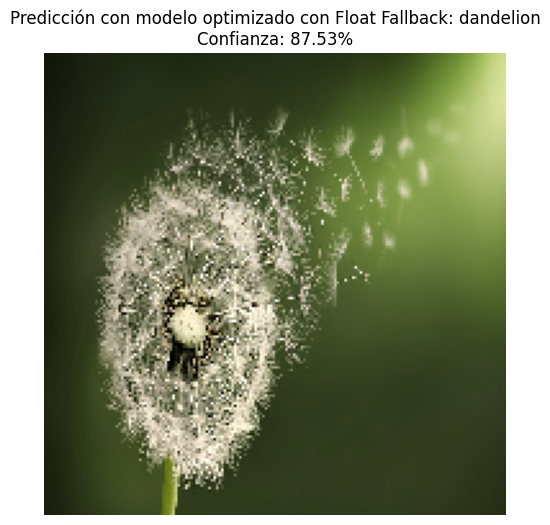

In [123]:
# Prueba de inferencia con el modelo optimizado con full integer
interpreter_fallback = Interpreter(model_path='tflite_int_fallback.tflite')
interpreter_fallback.allocate_tensors()
input_details = interpreter_fallback.get_input_details()
output_details = interpreter_fallback.get_output_details()

interpreter_fallback.set_tensor(input_details[0]['index'], img_array_tf)
interpreter_fallback.invoke()

predictions_fallback = interpreter_fallback.get_tensor(output_details[0]['index'])
score_fallback = tf.nn.softmax(predictions_fallback)

plt.figure(figsize=(6, 6))
plt.imshow(img_tf)
plt.title(f"Predicción con modelo optimizado con Float Fallback: {class_names[np.argmax(score_fallback)]}\nConfianza: {100 * np.max(score_fallback):.2f}%")
plt.axis('off')
plt.show()

#### Float16 Quantization

Esta técnica reduce el tamaño del modelo convirtiendo los pesos del modelo de un tipo de dato de punto flotante de 32 bits a un punto flotante de 16 bits.

In [118]:
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16] #Se especifica que el tipo de dato soportado será float16.
tflite_float16_model = converter_float16.convert()

# Guardar el modelo quantizado a float16
with open('tflite_float16_model.tflite', 'wb') as f:
    f.write(tflite_float16_model)

INFO:tensorflow:Assets written to: /tmp/tmpx58ekkze/assets


INFO:tensorflow:Assets written to: /tmp/tmpx58ekkze/assets


Saved artifact at '/tmp/tmpx58ekkze'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135666811476928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720751312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720743568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720748320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666720747616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135666721574928: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1728408023.814178   23732 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728408023.814199   23732 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-08 11:20:23.814442: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpx58ekkze
2024-10-08 11:20:23.815488: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-08 11:20:23.815511: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpx58ekkze
2024-10-08 11:20:23.823626: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-08 11:20:23.876286: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpx58ekkze
2024-10-08 11:20:23.895209: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 80772 microseconds.


In [120]:
float16_model_size_bytes = os.path.getsize('model_float16.tflite')
float16_model_size_mb = float16_model_size_bytes / (1024 ** 2)
print(f"Tamaño del modelo TensorFlow Lite (Float16): {float16_model_size_mb:.2f} MB")

Tamaño del modelo TensorFlow Lite (Float16): 7.61 MB


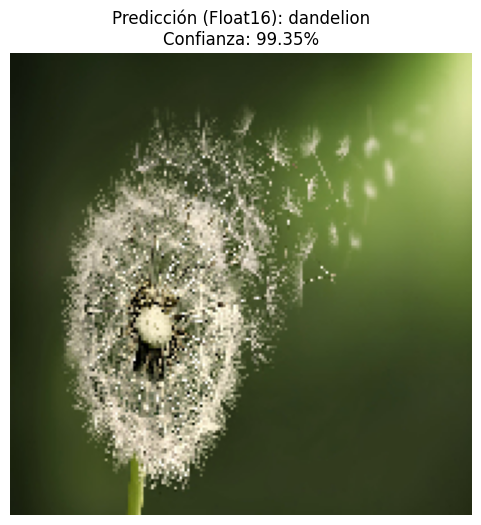

In [122]:
# Prueba de inferencia con el modelo (float16)
interpreter_float16 = Interpreter(model_path='tflite_float16_model.tflite')
interpreter_float16.allocate_tensors()
input_details = interpreter_float16.get_input_details()
output_details = interpreter_float16.get_output_details()

interpreter_float16.set_tensor(input_details[0]['index'], img_array_tf)
interpreter_float16.invoke()

predictions_float16 = interpreter_float16.get_tensor(output_details[0]['index'])
score_float16 = tf.nn.softmax(predictions_float16)


# Mostrar la imagen con la predicción del modelo Float16
plt.figure(figsize=(6, 6))
plt.imshow(img_tf)
plt.title(f"Predicción (Float16): {class_names[np.argmax(score_float16)]}\nConfianza: {100 * np.max(score_float16):.2f}%")
plt.axis('off')  # Quitar los ejes
plt.show()

## Qué sigue?

Visitar el sitio web de Lite RT para seguir aprendiendo sobre las utilidades de esta herramienta [Página principal](https://ai.google.dev/edge/litert?hl=es-419)